In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchnet
import torchvision.models as models
import torchvision.transforms as transforms
from munch import Munch
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

import dataset

In [2]:
## These requirements reflect the Python envirnoment used to train and test the DeepMiner system
# pytorch 0.2 and torchvision 0.1.9
# import sys
# import torchvision
# assert sys.version.startswith('2')
# assert torch.__version__.startswith('0.2')
# assert '0.1.9' in torchvision.__file__

In [3]:
## Load the pretrained network of your choice, need to run download_pretrained.sh to get these :

# pretrained alexnet
# config_path = 'pretrained/alexnet/config.yml'
# epoch = 45

# pretrained vgg16
#config_path = 'pretrained/vgg16/config.yml'
#epoch = 12

# pretrained inception_v3
#config_path = 'pretrained/inception_v3/config.yml'
#epoch = 7


## The difference between resnet152 and resnet152_3class
## is that the 3 class model predicts malignant/benign/normal
## and the 2 class model predicts cancer/no cancer.

# pretrained resnet152
config_path = 'pretrained/resnet152/config.yml'
epoch = 5

# pretrained resnet152_3class
config_path = 'pretrained/resnet152_3class/config.yml'
epoch = 5

In [4]:
## Load a model you trained yourself! More exciting than the ones above ;)

#config_path = 'logs/your_log_dir/config.yml'
#epoch = your_best_epoch

In [5]:
# Extract model information such as Pytorch Checkpoint filename from config.yml

with open(config_path, 'r') as f:
    cfg = Munch.fromYAML(f)

In [6]:
# Create model instance from achitecture specified in config.yml

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

print("=> creating model '{}'".format(cfg.arch.model))
model = models.__dict__[cfg.arch.model](pretrained=cfg.arch.pretrained)

if cfg.arch.model.startswith('alexnet') or cfg.arch.model.startswith('vgg'):
    model.classifier._modules['6'] = nn.Linear(4096, cfg.arch.num_classes)
elif cfg.arch.model == 'inception_v3':
    model.aux_logits = False
    model.fc = nn.Linear(2048, cfg.arch.num_classes)
elif cfg.arch.model == 'resnet152':
    model.fc = nn.Linear(2048, cfg.arch.num_classes)
else:
    raise Exception

if cfg.arch.model.startswith('alexnet') or cfg.arch.model.startswith('vgg'):
    model.features = torch.nn.DataParallel(model.features)
else:
    model = torch.nn.DataParallel(model)

# In case you have a GPU    
if torch.cuda.is_available():
    model.cuda()    
cudnn.benchmark = True

=> creating model 'resnet152'


In [7]:
# Load pretrained model

resume_path = cfg.training.resume.replace(cfg.training.resume[-16:-8], '{:08}'.format(epoch))
if os.path.isfile(resume_path):
    print("=> loading checkpoint '{}'".format(resume_path))
    if torch.cuda.is_available():
        # Pretrained models were created with CUDA enabled
        checkpoint = torch.load(resume_path)
    else:
        # For if you want to run this notebook with pretrained models on a CPU only machine
        checkpoint = torch.load(resume_path, map_location='cpu')
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    print("=> loaded checkpoint '{}' (epoch {})".format(resume_path, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume_path))
    print('')
    raise Exception

=> loading checkpoint 'pretrained/resnet152_3class/checkpoint_00000005.pth.tar'
=> loaded checkpoint 'pretrained/resnet152_3class/checkpoint_00000005.pth.tar' (epoch 5)


In [8]:
# Check! Location of ddsm image files. Need to run download_data.sh to make this work.
print(cfg.data.root)

../data/ddsm_3class


In [9]:
# Create preprocessing transform, classic ImageNet mean and std

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
val_transforms = []
if cfg.arch.model == 'inception_v3':
    val_transforms.append(transforms.Resize(299))
else:
    val_transforms.append(transforms.Resize(224))
val_dataset = dataset.DDSM(cfg.data.root, 'val', transforms.Compose(val_transforms + [
    transforms.ToTensor(),
    normalize,
]))
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=10, #cfg.data.batch_size 
    shuffle=False,
    num_workers=cfg.data.workers, pin_memory=True)

In [10]:
# Print some details about the validation set we will be using to calculate ROC
# Just a check to make sure everything is where we expect

print(f'Val set size = {len(val_dataset)}')
print(f"Number of unique patients in val set: {len(set([s[0].split('/')[-1].split('-x')[0] for s in val_dataset.image_list]))}")
print(f'Example fname from val set: {val_dataset.image_list[0]}')


Val set size = 44612
Number of unique patients in val set: 1040
Example fname from val set: ('images/778/benign_01-B_3099_1.LEFT_CC.LJPEG.1-x630_y0_w630_h630_imgfrac0.25_stridefrac0.5.jpg', 0)


In [ ]:
# Predict class for validataion samples

targets = [[] for _ in range(cfg.arch.num_classes)]
probs = [[] for _ in range(cfg.arch.num_classes)]
aucs = [torchnet.meter.AUCMeter() for _ in range(cfg.arch.num_classes)]

for inp, target in tqdm(val_loader):
    input_var = Variable(inp, volatile=True)
    output = model(input_var)
    prob = nn.Softmax()(output)
    for i in range(cfg.arch.num_classes):
        aucs[i].add(prob[:, i].data, target == i)
        targets[i].extend(target.numpy() == i)
        probs[i].extend(prob[:, i].data.cpu().numpy())

Widget Javascript not detected.  It may not be installed or enabled properly.



class 0
torchnet.meter.AUCMeter: 0.8757150899236701
sklearn.metrics.roc_auc_score: 0.8757150468388264

class 1
torchnet.meter.AUCMeter: 0.8757151545509355
sklearn.metrics.roc_auc_score: 0.8757151437797249



In [12]:
# Print per-class AUC values, using torchnet AUC function

for i in range(cfg.arch.num_classes):
    print('class {}'.format(i))
    print('torchnet.meter.AUCMeter: {}'.format(aucs[i].value()[0]))
    print('sklearn.metrics.roc_auc_score: {}'.format(roc_auc_score(targets[i], probs[i])))
    print('')

class 0
torchnet.meter.AUCMeter: 0.8375320925944765
sklearn.metrics.roc_auc_score: 0.8375319942715769

class 1
torchnet.meter.AUCMeter: 0.8016790411598226
sklearn.metrics.roc_auc_score: 0.8016790411598226

class 2
torchnet.meter.AUCMeter: 0.8720779966650607
sklearn.metrics.roc_auc_score: 0.8720779966650607



In [13]:
# Plot ROC for one class
def plot_roc_curve(y_true, y_score):
    plt.figure(figsize=(8, 8))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.gca().set_aspect('equal')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, color='black')
    plt.show()

class 0


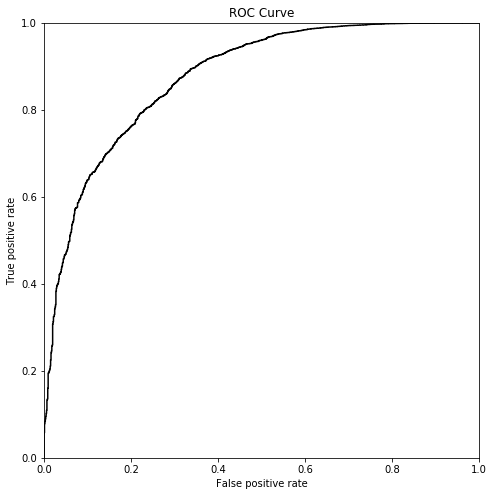

class 1


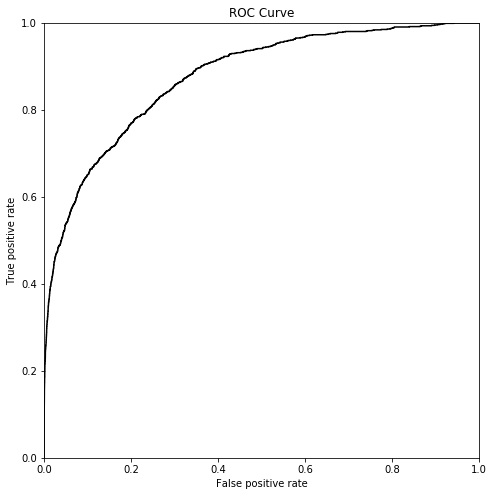

class 2


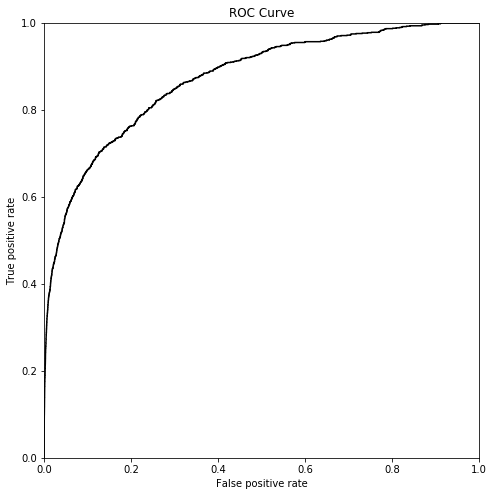

In [15]:
# ROC plots for each class
for i in range(cfg.arch.num_classes):
    print('class {}'.format(i))
    plot_roc_curve(targets[i], probs[i])

In [18]:
import numpy as np
def partial_auc(fpr, tpr, thresh):
    loc = len([t for t in tpr if t >= thresh])
    pAUC = np.trapz(tpr[-1*loc:], fpr[-1*loc:]) * (1-thresh)
    return pAUC

In [21]:
# Print partial AUC over threshold of 0.8 

i = 1
fpr, tpr, _ = roc_curve(targets[i], probs[i])
pAUC = partial_auc(fpr, tpr, 0.8)
print(pAUC)

0.12110417213860836


In [30]:
# Plot for all 3 classes' ROC and pAUC 

from sklearn.metrics import auc
from numpy import interp
from itertools import cycle 
def plot_multi_roc_curve(ys_true, ys_score, legend):
    n_classes = len(ys_true)
    
    # First aggregate all false positive rates
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    pauc = dict()
    for i in range(n_classes):        
        fpr[i], tpr[i], _ = roc_curve(ys_true[i], ys_score[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        pauc[i] = partial_auc(fpr[i], tpr[i], thresh = 0.8)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Plot all ROC curves
    plt.figure(figsize=(8, 8))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.gca().set_aspect('equal')
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='Class {0} ( AUC = {1:0.3f}, pAUC = {2:0.3f} )'
                 ''.format(legend[i], roc_auc[i], pauc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.plot([0, 1], [0.8, 0.8], color='navy', linestyle=':', 
             lw=lw, label='Partial AUC threshold = 0.8 TPR')

    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    #plt.title('ResNet152 3class ROC')
    plt.legend(loc="lower right", fontsize=12)
    plt.show()


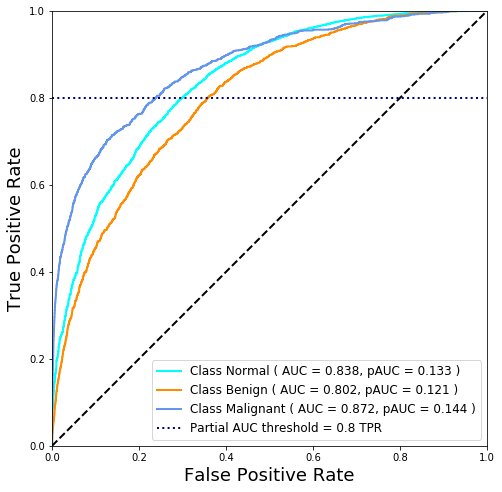

In [32]:
# ROC curves for each class overlayed, with pAUC indicated
plot_multi_roc_curve(targets, probs, ['Normal', 'Benign', 'Malignant'])

In [25]:
# Average Precision of this model
# Please note this AP score is caluclated using the sklearn method, 
# which is not the standarad Pascal VOC AP metric.
# Included for reference only.
from sklearn.metrics import average_precision_score
print(f'AP for this model: {average_precision_score(targets[1],probs[1])}')

AP for this model: 0.12492922766332668
